# Starbucks Capstone Challenge

## Project Definition

### Project Overview

In today's highly competitive market, businesses are constantly looking for ways to improve their marketing strategies and increase their revenue.

One way to do this is by using data science techniques to predict customer behavior and tailor marketing campaigns accordingly.
In this report, I present a study that aimed to predict whether users of the Starbucks app will view offers if they are sent to them. The study employed a powerful machine learning techniques known as a Random Forest Classifier, Logistic Regression and K-Nearest Neighbors to make these predictions.

The data set in the data/ directory contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free).

### Problem Statement

In an ideal world, every offer that Starbucks sends out to it's users would be viewed and then completed. 

In reality, these offers are sent out to a large number of users who never actually view them. These same users frequently complete the offer without even knowing they have done so. 

Providing these discount to these unaware users results in a loss of revenue for Starbucks.
What I will do is show how I have created a model that will predict whether or not a user will view the selected offer based on their demographic information as well as the offer information itself. 

The model itself will be a binary classification estimator. I initially chose Random Forrest Classifier, Logistic Regression and K-Nearest Neighbors as classifiers to try out. They will simply be trying to predict whether an offer will be viewed (1) or not viewed (0) by the user.

By utilizing a model like this, Starbucks can reduce the number of generous discounts being handed out to all users and therefore limit this loss of revenue.

### Metrics

The primary metric that will steer this project will be the recall score. 

The reason I have chosen this metric is because we have a strong desire to reduce/minimise the the number of False Negatives we classify (*we thought the user would view the offer, but they actually didn't = Bad*)

### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Analyses

## Get Raw Data

In [1]:
# import libraries that are likely to be used
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration

The first step in the analysis I conducted was to clean the data that I had at hand for the users and offers of the Starbucks app. Below are the heads and subsequent exploration of the 3 respective datasets I inherited; portfolio, profile and transcript.

### Portfolio data set 

In [37]:
# check the portfolio dataframe
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [39]:
# Take a look at the numerical columns in the portfolio data set 
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


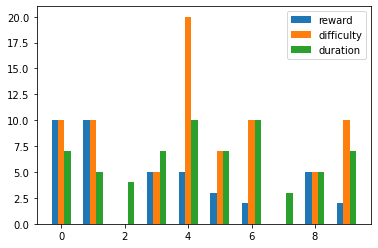

In [51]:
width = 0.2
plt.bar(portfolio['reward'].index-width, portfolio['reward'].values, width, label='reward')
plt.bar(portfolio['difficulty'].index, portfolio['difficulty'].values, width, label='difficulty')
plt.bar(portfolio['duration'].index+width, portfolio['duration'].values, width, label='duration')
plt.legend()
plt.show()

In [36]:
# Take a look at the non-numerical columns in the portfolio data set 
portfolio.channels.value_counts()

[web, email, mobile, social]    4
[web, email, mobile]            3
[email, mobile, social]         2
[web, email]                    1
Name: channels, dtype: int64

In [40]:
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

### Profile data set 

In [52]:
# check the profile dataframe
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-01-12 00:02:00,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-01-15 00:07:00,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-01-12 00:07:00,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-01-09 00:05:00,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-01-04 00:08:00,NaN


A large number users have ages that would put them in the top 5 oldest people ever recorded (> 117 years old ). This is an obvious error that aligns with the Null/NaN values we see in other columns.

Later on I will go to remove these NaN values. In doing so it did result in a loss of around 13% of the users and their interactions from the dataset. I saw this as a reasonable initial compromise to make given the large size of the dataset and the time it would save to simply remove those users and get early feedback from this simple dataset to steer the project.

If the final results came back with abnormalities, I could then think about re-instating these users and finding a way of filling in the missing data. This could be done by filling in the missing/null values with the mean values of users similar to them.

In [53]:
# Check percentage of `NaN` data in profile columns
(profile.isnull().sum()/profile.shape[0])*100

gender              12.794118
age                  0.000000
id                   0.000000
became_member_on     0.000000
income              12.794118
dtype: float64

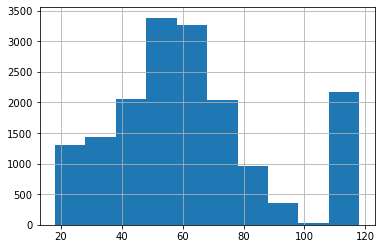

In [56]:
# check distribution of age data 
profile.age.hist();

### General observations

It looks as though users that have a null value in one column (eg, gender) also have a default value of 118 for age and a null value for income. I believe this will be due to a way they have signed up to starbucks. 

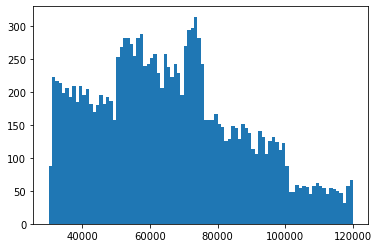

In [68]:
# Check the distribution of the income data
plt.hist(profile['income'], bins=90);

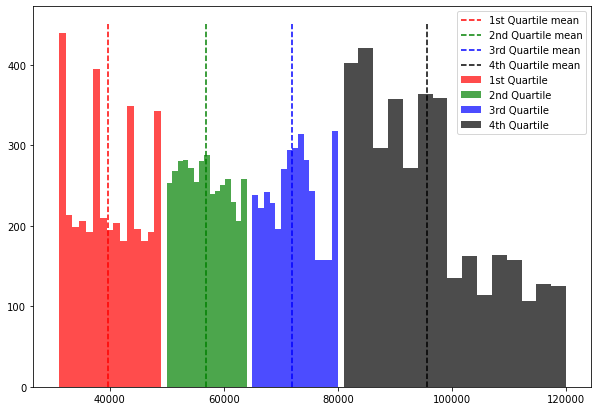

In [87]:
# Check the quartiles for income 
perc_25 = profile_new['income'].describe()[4]
perc_50 = profile_new['income'].describe()[5]
perc_75 = profile_new['income'].describe()[6]

# create a list of quartiles and their values (not pretty but does the job)
perc_dist = [['1st Quartile',profile_new['income'].min()], ['2nd Quartile',perc_25], ['3rd Quartile',perc_50], ['4th Quartile',perc_75], ['Null',profile_new['income'].max()]]

income_dict = {}
for i in perc_dist:
    ii_loc = perc_dist.index(i)+1
    try:
        ii = perc_dist[ii_loc]
        income_dict[i[0]] = profile_new[(profile_new['income'] > i[1]) & (profile_new['income'] <= ii[1])]
    except:
        continue

# plot the quartiles for the income data
fig, ax = plt.subplots(figsize=(10,7))
col = ['r','g', 'b','k']
i=0
for key,df in income_dict.items():
    if df.income.mean()>0:
        plt.hist(df.income, bins=15, label=key, color = col[i],  alpha = 0.7)
        mean = df.income.mean()
        plt.plot([mean, mean], [0, 450],'--', color = col[i], label=key+' mean')
        i+=1
plt.legend()
    
plt.show()

### Transcript data set 


In [88]:
transcript.head()

,person,event,value,time,type,type_vals
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,offer_id,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,offer_id,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,offer_id,4d5c57ea9a6940dd891ad53e9dbe8da0


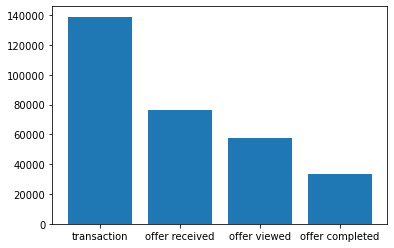

In [90]:
# See the counts of the respective offer events
plt.bar(transcript.event.value_counts().index,transcript.event.value_counts());

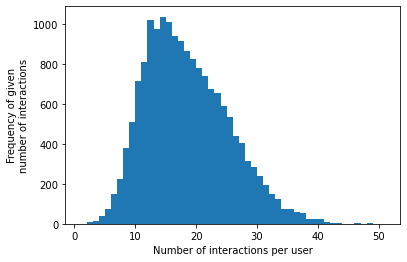

In [95]:
# plot the distribution of the number of the number of interactions per user
plt.hist(transcript.person.value_counts(), bins=50);
plt.xlabel('Number of interactions per user');
plt.ylabel('Frequency of given\nnumber of interactions');
plt.show()

## Data Cleaning

In [96]:
def clean_portfolio(portfolio_df):
    ''' 
    Function to clean the portfolio of starbucks offers. It returns a new_portfolio 
    with 'channels' and 'offer_type' dummied so each variable within their original column
    is now an explicit binary column itself.
    
    INPUTS
    portfolio_df - portfolio dataframe of starbucks offers
    
    OUTPUTS
    new_portfolio - clean portfolio 
    
    '''
    # dummy the channel column and merge to the portfolio df
    portfolio_dechanelled = portfolio_df.reset_index().merge(pd.get_dummies(portfolio_df['channels'].apply(pd.Series).stack()).sum(level=0).reset_index(), on='index').drop(columns=['index', 'channels'])
    new_portfolio = portfolio_dechanelled.reset_index().merge(pd.get_dummies(portfolio_dechanelled['offer_type'].reset_index()), on='index').drop(columns=['index', 'offer_type'])
    
    #rename the id column to explicit offer_id 
    new_portfolio=new_portfolio.rename(columns={'id':'offer_id'})
    
    return new_portfolio 

def clean_profile(df, get_dates=False):
    '''
    Function to clean the profile of starbucks users. Change column type for 'became_member_on',
    drop NaN value rows and dummy genders to separate columns. Optionally can extract features from became_member_on. 
    
    INPUTS
    df - profile dataframe of starbucks users
    get_dates - Boolean for whether user wants extra date feature columns
    
    OUTPUTS
    new_profile - clean profile of users
    
    '''
    # Turn became_member_on to a date type
    profile['became_member_on']=pd.to_datetime(profile['became_member_on'], format='%Y%M%d')
   
    # drop NaN rows
    profile_drop = profile.dropna(how='any', axis=0)
    
    #rows_lost = profile.shape[0]- profile_drop.shape[0]
    if get_dates:
        # get year, month and day columns from became_member_on column
        profile_drop['year']=profile_drop['became_member_on'].dt.year
        # Interesting to note there is only data for January sign ups here
        profile_drop['month']=profile_drop['became_member_on'].dt.month
        profile_drop['day']=profile_drop['became_member_on'].dt.day
        profile_drop['weekday']=profile_drop['became_member_on'].dt.weekday
    
    # Rename column id to person (for easier merging later on)
    new_profile = profile_drop.rename(columns={'id':'person'})

    # get dummy cols for gender column
    gender_dums = pd.get_dummies(new_profile.gender)

    # merge new_profile with gender_dums to get finished new_profile
    new_profile = new_profile.reset_index().merge(gender_dums.reset_index(),on='index').drop(columns=['index', 'gender', 'became_member_on'])
    
    return new_profile

def get_transaction_timeline(transcript_df):
    '''
    Function to show timeline of transactions for each user from start of test to end of the test
    
    INPUTS
    transcript_df - original transcript dataframe
    
    OUTPUTS
    user_transactions_tl - Timeline of users transactions 
    
    '''
    # group users and then group by time. sum the output so we get total spend at each time for user
    user_transactions_tl = transcript_df[transcript_df['offer_id']==0].groupby(by=['person', 'time']).sum()
    
    # drop unnecessary columns
    user_transactions_tl= user_transactions_tl.drop(columns=transcript_df.loc[:,'offer completed':'time_offer_viewed'].columns).reset_index()
    
    return user_transactions_tl

def clean_transcript(transcript_df):
    '''
    Function to clean the transcript of starbucks users and offers. 
    
    INPUTS
    transcript_df - original transcript dataframe
    
    OUTPUTS
    offers_n_spend - clean offers and transactions df
    
    '''
    
    # separate the value column dictionaries in to new columns
    #     'type' = transaction or offer
    #     'type_vals' = value of that transaction or offer
    val_list = []
    for x in list(transcript_df['value']):
        try:
            val_list.append([list(x.keys())[0],list(x.values())[0]])
        except:
            val_list.append(None, None)
            continue

    val_type = [x[0].replace(' ', '_') for x in val_list]
    val_vals = [x[1] for x in val_list]

    transcript_df['type'] = val_type
    transcript_df['type_vals'] = val_vals

    # get dummies for event column 
    event_dums = pd.get_dummies(transcript.event)
    # get dummies for type column
    type_dums = pd.get_dummies(transcript.type)

    # get 'status' columns for offers

    # merge dummied event column to transcript 
    transcript_de_event = transcript.reset_index().merge(event_dums.reset_index(), on='index').drop(columns=['index', 'event', 'value'])

    # merge above df to type_dums 
    dums_transcript = transcript_de_event.reset_index().merge(type_dums.reset_index(), on='index').drop(columns=['index', 'type'])

    # get time of offer action
    offer_cols = ['offer completed', 'offer received','offer viewed']

    for col in offer_cols:
        name_col = 'time_'+col.replace(' ', '_')
        # create new columns for time they had actions complete
        dums_transcript[name_col] = dums_transcript[dums_transcript[col]==1].time

    dums_transcript.sort_values(by=['person', 'time'])
    
    # create transactions column and make it numeric 
    dums_transcript['transactions'] = pd.to_numeric(dums_transcript[dums_transcript['transaction']==1]['type_vals'])
    # create an offer column 
    dums_transcript['offer'] = dums_transcript[dums_transcript['offer_id']==1]['type_vals']
    
    # remove redundant column
    dums_transcript = dums_transcript.drop(columns='type_vals')
    
    # get how many times they've received a certain offer
    offer_count_transcript = dums_transcript.sort_values(by=['person', 'offer', 'time'])
    offer_count_transcript['received_offer_count'] = offer_count_transcript.groupby(by=['person','offer'])['offer received'].cumsum()

    # get the offers df 
    offers = offer_count_transcript.groupby(['person', 'offer', 'received_offer_count']).sum().reset_index()
    # get the transactions
    transactions = get_transaction_timeline(dums_transcript)
    
    # drop un-needed columns
    offers = offers.drop(columns=['time', 'transaction', 'amount', 'offer_id', 'transactions'])
    
    # rebaseline actions so they're independent of test time
    offers['time_offer_completed'] = abs(offers['time_offer_completed']-offers['time_offer_received'])
    offers['time_offer_viewed'] = abs(offers['time_offer_viewed']-offers['time_offer_received'])
    offers['time_offer_received'] = abs(offers['time_offer_received']-offers['time_offer_received'])
    
    # get users total spend
    user_tot_spend = transactions.groupby(['person']).sum().reset_index().drop(columns=['time'])
    
    # merge offers and spend together
    offers_n_spend = offers.merge(user_tot_spend, on='person')
    
    return  offers_n_spend

def merge_three_dfs(new_transcript, new_profile, new_portfolio):
    '''
    Function to merge the 3 cleaned starbucks datasets. 
    
    INPUTS
    new_transcript - clean transcript df
    new_profile - clean profile df
    new_portfolio - clean portfolio df
    
    OUTPUTS
    master_df - cleaned dataset ready for analysis/prediction modelling
    
    '''
    new_transcript = new_transcript.rename(columns={'offer':'offer_id'})
    
    master_df = new_transcript.merge(new_profile, on='person')
    master_df = master_df.merge(new_portfolio, on='offer_id')
    
    master_df = master_df.drop(columns=['person', 'offer_id'])
    return master_df

In [97]:
# check the portfolio dataframe
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [98]:
# clean portfolio df 
new_portfolio=clean_portfolio(portfolio)
new_portfolio.head()

,reward,difficulty,duration,offer_id,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


In [5]:
# check the profile dataframe
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [99]:
# clean profile df
profile_new = clean_profile(profile)
profile_new.head()

,age,person,income,F,M,O
0,55,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0
1,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0
2,68,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0
3,65,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0
4,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0


In [100]:
# check the transcript dataframe
transcript.head()

,person,event,value,time,type,type_vals
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,offer_id,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,offer_id,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,offer_id,4d5c57ea9a6940dd891ad53e9dbe8da0


In [101]:
# clean transcript df
new_transcript = clean_transcript(transcript)
new_portfolio.head()

,reward,difficulty,duration,offer_id,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


In [102]:
#merge the 3 datasets we have cleaned 
master_df = merge_three_dfs(new_transcript, profile_new, new_portfolio)

In [103]:
master_df.head()

,received_offer_count,offer completed,offer received,offer viewed,time_offer_completed,time_offer_received,time_offer_viewed,transactions,age,income,...,reward,difficulty,duration,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,1,1,1,0,0.0,0.0,576.0,127.60,33,72000.0,...,2,10,7,1,1,0,1,0,1,0
1,1,0,1,0,408.0,0.0,408.0,68.51,19,65000.0,...,2,10,7,1,1,0,1,0,1,0
2,2,0,1,0,576.0,0.0,576.0,68.51,19,65000.0,...,2,10,7,1,1,0,1,0,1,0
3,1,0,1,0,408.0,0.0,408.0,20.36,56,47000.0,...,2,10,7,1,1,0,1,0,1,0
4,1,1,1,1,30.0,0.0,60.0,375.12,58,119000.0,...,2,10,7,1,1,0,1,0,1,0


In [104]:
# Drop potentially unrequired columns (Edit this as required by reader)
drop_master_df = master_df.drop(columns=['received_offer_count', 'offer completed', 
                                 'offer received', 'time_offer_completed', 'time_offer_received',
                                 'time_offer_viewed'])

In [105]:
# check the columns we have left 
list(drop_master_df.columns)

['offer viewed',
 'transactions',
 'age',
 'income',
 'F',
 'M',
 'O',
 'reward',
 'difficulty',
 'duration',
 'email',
 'mobile',
 'social',
 'web',
 'offer_type_bogo',
 'offer_type_discount',
 'offer_type_informational']

In [18]:
# Show the ratio of users that DON'T view offers sent to them compared to those that DO
print('No View to View ratio: \t1:', round(1/(drop_master_df[drop_master_df['offer viewed']==0].count()/drop_master_df[drop_master_df['offer viewed']==1].count())['offer viewed'],2))

No View to View ratio: 	1: 2.99


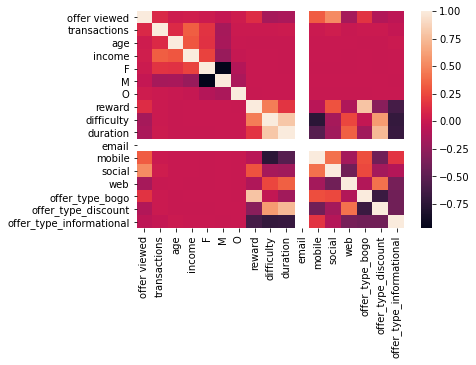

In [106]:
heatmap = sns.heatmap(drop_master_df.corr());
fig = heatmap.get_figure()

# save figure if required
# fig.savefig("heatmap.png")

By looking at the correlation between variables in the final dataset, we can see that their doesn't seem to be any large correlation between the users and the types of offers they receive. This is shown by the sea of red in the top right and lower left portion of the below graph. 

For that reason, I don't believe these offers are being tailored to each demographic of users.

What's interesting to see here is that the 'offer viewed' column does have a varying degree of correlation across it.

The image below shows the ranked correlation between the 'offer viewed' column and the other variables.

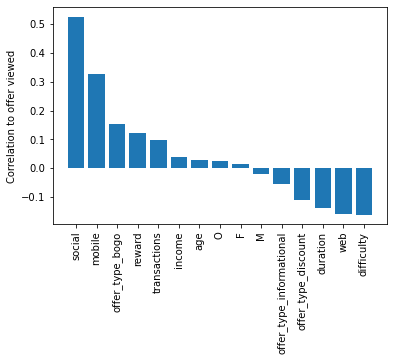

In [107]:
# check the strongest and weakest correlations to 'offer viewed' variable
plt.bar(drop_master_df.corr()['offer viewed'].sort_values(ascending=False).index[1:-1], drop_master_df.corr()['offer viewed'].sort_values(ascending=False).values[1:-1]);
plt.xticks(rotation=90);
plt.ylabel('Correlation to offer viewed');

Users tend to view offers when sent through social media which is more typically found whilst browsing through their mobile (this is pretty intuitive given phones are now seemingly just an extension of our bodies these days). 

They are also more responsive to the more generous types of offers such as Buy One Get One Free and high value rewards

## Prediction Modelling 

### Methodology
Now the data is clean and I have an idea of what the data looks like visually, I set about starting to create a model that would predict whether a user, if given a particular offer, would view the offer.

As this is a classification problem, I chose the Random Forrest Classifier, Logistic Regression and K-Nearest Neighbours as classifiers to trial. I was able to fine tune the hyper-parameters using StratifiedKFold and GridSearch within a Pipeline.

### Implementation
Pipelines in data science are used to simplify the process of building and evaluating machine learning models by allowing multiple steps of the model building process to be chained together and treated as a single unit. They are particularly useful for reducing the amount of code required to implement a complex machine learning workflow, and for ensuring that all of the steps in the process are executed in the correct order.

The StratifiedKFold method ensured that each fold of the data in the training set contained a representative proportion of the different class labels. This is particularly useful when dealing with imbalanced datasets, where one class may have significantly more samples than the other(s). We can see from the data for this project there are significantly more users that view the offers compared to those that do. This means that a dumb model could just guess that user will view the offer 75% of the time and it provide a reasonable accuracy.

GridSearchCV is a method for fine-tuning machine learning models by searching for the best combination of hyper-parameters. It does this by training the model on different combinations of hyper-parameters from a predefined grid and evaluating the performance of each combination. The combination of hyper-parameters that results in the best performance is then chosen as the optimal set.

By using StratifiedKFold in conjunction with GridSearchCV and Pipeline, we can fine-tune a machine learning model by systematically searching for the best combination of hyper-parameters that results in the best performance on a representative sample of the data.

I utilized this methodology for each of the classifiers previously mentioned.

In [108]:
# pre-processing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

# Pipeline libraries
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix

# model libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# post-processing libraries
from sklearn.metrics import r2_score, mean_squared_error,  precision_recall_curve, make_scorer, recall_score, accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn import metrics


def conf_matrix(act, pred):
    '''
    Display a confusion matrix to define the performance of the classification algorithm.
    
    INPUTS
    act - actual values associated with the variable that we're trying to predict
    pred - predicted values associated with the variable that we're trying to predict
    
    OUTPUTS
    Dsiplays a confusion matrix to the screen and returns a dictionary with key performance indicators 
    (Recall, Precision and F1 Scores)
    
    '''
    confusion_matrix = metrics.confusion_matrix(act, pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot()
    plt.show()
    
    recall = recall_score(act, pred, average='binary')
    precision = precision_score(act, pred, average='binary')
    score = f1_score(act, pred, average='binary')
    return {'Recall':recall, 'Precision':precision,'F1': score}


def ranfor_grid_search_wrapper(refit_score='recall_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization on Random Forest model
    
    INPUTS
    refit_score - choose between 'precision_score', 'recall_score' and 'accuracy_score'
    
    OUTPUTS
    grid_search - GridSearchCV object 
    """
    clf = RandomForestClassifier(n_jobs=-1) 
    
    param_grid = {
        'min_samples_split': [2, 3, 4], 
        'n_estimators' : [75, 100, 125],
        'max_depth': [5, 6, 7],
        'max_features': [20, 25]
    }

    scorers = {
        'precision_score': make_scorer(precision_score),
        'recall_score': make_scorer(recall_score),
        'accuracy_score': make_scorer(accuracy_score)
    }


    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    
    return grid_search

def logreg_grid_search_wrapper(refit_score='recall_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization on Logistic Regression model
    
    INPUTS
    refit_score - choose between 'precision_score', 'recall_score' and 'accuracy_score'
    
    OUTPUTS
    grid_search - GridSearchCV object
    """
    clf = LogisticRegression(n_jobs=-1)
    
    param_grid = {
            'solver': ('lbfgs', 'liblinear'),
            'fit_intercept': (True, False),
            'C': [0.01, 0.1, 1, 10, 100]
    } 

    scorers = {
        'precision_score': make_scorer(precision_score),
        'recall_score': make_scorer(recall_score),
        'accuracy_score': make_scorer(accuracy_score)
    }


    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    
    return grid_search

def knn_grid_search_wrapper(refit_score='recall_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization on K-Nearest Neighbors model
    
    INPUTS
    refit_score - choose between 'precision_score', 'recall_score' and 'accuracy_score'
    
    OUTPUTS
    grid_search - GridSearchCV object
    """
    clf = KNeighborsClassifier(n_jobs=-1)
    
    param_grid = {
            'n_neighbors': (5, 8),
            'weights': ('uniform', 'distance'),
            'p': (1,2),
            'leaf_size': (10, 15)
    }

    scorers = {
        'precision_score': make_scorer(precision_score),
        'recall_score': make_scorer(recall_score),
        'accuracy_score': make_scorer(accuracy_score)
    }


    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)

    return grid_search


def workflow(df, mod='logreg', pred_col = 'offer viewed', drop_cols=[]):
    
    '''
    Overall workflow for hyper-parameter tuning using Pipeline, StratifiedKFold and GridsearchCV
    
    INPUTS
    df - Clean dataframe of all required Starbucks users/offers info
    mod - Choose between 'logreg', 'knn', 'ranfor' to choose which classifier to use
    pred_col - the variable column that you are trying to predict
    drop_cols - Any further columns you want to drop prior to model creation/tuning

    OUTPUTS
    test_score - r2 score for the testing data
    train_score - r2 score for the training data
    model - optimised model 
    X_train - training data
    X_test - testing data
    y_train - target training variables
    y_test - target testing variables
    more_scores - dictionary of additional scores -> recall, precision and f1 scores
    
    '''
    
    drop_cols.append(pred_col)
    
    X = master_df.drop(columns=drop_cols)
    y = master_df[pred_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    scaler = StandardScaler()  
    # Don't cheat - fit only on training data
    scaler.fit(X_train)  
    X_train = scaler.transform(X_train)  
    # apply same transformation to test data
    X_test = scaler.transform(X_test)  
    
    if mod == 'knn':
        model = knn_grid_search_wrapper()  # Change this
        
    elif mod == 'ranfor':
        model = ranfor_grid_search_wrapper()  # Change this
        
    elif mod== 'logreg':
        model = logreg_grid_search_wrapper()  # Change this
    else:
        print('No model suggested...')
        exit()

    model.fit(X_train, y_train)
    
    print("[INFO] Model built, fit and optimised successfully")
    print("\n[INFO] Optimised parameters:")
    try:
        print("\t", model.best_params_)
    except:
        print("Can't print Best Parameters")
    
    #Predict using your model
    y_test_preds = model.predict(X_test)
    y_train_preds = model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)
    
    more_scores = conf_matrix(y_test, y_test_preds)
    for key, val in more_scores.items():
        print(key, ": ", round(val,4))

    return test_score, train_score, model, X_train, X_test, y_train, y_test, more_scores

## Results

### Random Forest Classifier

[INFO] Model built, fit and optimised successfully

[INFO] Optimised parameters:
	 {'max_depth': 5, 'max_features': 20, 'min_samples_split': 2, 'n_estimators': 100}


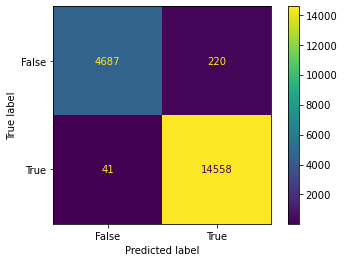

Recall :  0.9972
Precision :  0.9851
F1 :  0.9911


In [109]:
ranfor_test_score, ranfor_train_score, ranfor_model, ranfor_X_train, ranfor_X_test, ranfor_y_train, ranfor_y_test, ranfor_more_scores = workflow(drop_master_df, mod = 'ranfor', pred_col = 'offer viewed')

In [112]:
# r2 train score
ranfor_train_score

0.9263390360919556

In [113]:
# r2 test score
ranfor_test_score

0.9289327417773868

### Logistic Regression 

[INFO] Model built, fit and optimised successfully

[INFO] Optimised parameters:
	 {'C': 0.01, 'fit_intercept': True, 'solver': 'lbfgs'}


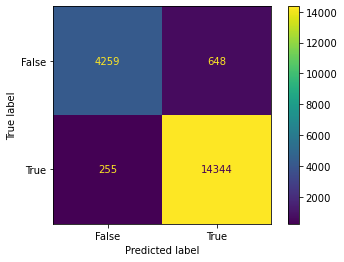

Recall :  0.9825
Precision :  0.9568
F1 :  0.9695


In [114]:
logreg_test_score, logreg_train_score, logreg_model, logreg_X_train, logreg_X_test, logreg_y_train, logreg_y_test, logreg_more_scores = workflow(drop_master_df,  mod = 'logreg', pred_col = 'offer viewed')

In [115]:
# r2 train score
logreg_train_score

0.7450557735646857

In [116]:
# r2 test score
logreg_test_score

0.7541236238504992

### K-Nearest Neighbors 

[INFO] Model built, fit and optimised successfully

[INFO] Optimised parameters:
	 {'leaf_size': 10, 'n_neighbors': 8, 'p': 2, 'weights': 'distance'}


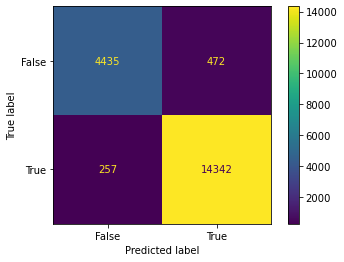

Recall :  0.9824
Precision :  0.9681
F1 :  0.9752


In [117]:
knn_test_score, knn_train_score, knn_model, knn_X_train, knn_X_test, knn_y_train, knn_y_test, knn_more_scores = workflow(drop_master_df,  mod = 'knn', pred_col = 'offer viewed')

In [118]:
# r2 train score
knn_train_score

1.0

In [119]:
# r2 test score
knn_test_score

0.801501795998908

### Speed Test

In [120]:
import timeit

# Number of runs to complete
runs = 100
# Reduced runs to speed up analysis
runs_2 = 10
print('RandomForestClassifier: ',timeit.timeit(lambda: ranfor_model.predict(ranfor_X_test), number=runs)/runs)
print('LogisticRegression: ',timeit.timeit(lambda: logreg_model.predict(logreg_X_test), number=runs)/runs)
print('KNearestNeighbour: ',timeit.timeit(lambda: knn_model.predict(knn_X_test), number=runs_2)/runs_2)

RandomForestClassifier:  0.05469024699999864
LogisticRegression:  0.0008203950000097393
KNearestNeighbour:  2.3190337800000633


## Conclusion

If I was to suggest a classifier from these results I would choose the Random Forest Classifier if speed of prediction is not essential. I believe this is true for this project as there is no 'urgency' to hand out offers at a fast rate.
However, this project does have room for improvement and additional analyses could be added on to the back of this to increase revenue further. 

This could be done by bolting on a prediction of how this offer will affect the users transactions. Will the offer provide an incentive to the user to spend more than they originally would have? Or will it make the user just take advantage of a singular discounted product. 

To be able to do this, I envisage I would need to group the data so that we had the total value of their transactions before and after the offer, and the after column would provide us with a variable to predict. The model used here would be a regression model.

With that this improvement in mind, each step along the workflow may then be time bound. In this improved scenario, I would choose the Logistic Regression model as this provides a good balance of a high recall score and fast predicting performance.

## Reflection

In this post, I showed three different machine learning models were used to predict whether Starbucks users would view offers. 
The models used were Random Forest Classifier, Logistic Regression, and k-Nearest Neighbors. 

The dataset used for the analysis included information on customer demographics, transaction history, and offer details. 
The results of the analysis showed that the Random Forest Classifier performed the best, with a recall score of 99.7%, followed by k-Nearest Neighbors with a recall score of 98.3 % and Logistic Regression with a recall score of 98.2%. It was concluded that the Random Forest Classifier is the most suitable model for this particular task due to its ability to handle a large number of input variables and its higher accuracy rate. 

However, an improvement could be made by adding further steps to this project which could predict the affect on additional revenue the selected offer may have on the user. If we continued with this, Logistic Regression would provide a faster initial prediction whilst maintaining a comparable recall score.